In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 12 variables share a factor structure and the other 8 are noise

In [9]:
N = 500000
D_factor = 10
D_noise = 10
P = 3

V = np.abs(np.random.normal(1., 1., size=(P,D_factor)))
Z = np.abs(np.random.normal(0.1, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor*2))
X[:, ::2] = np.random.poisson(ZV)
X[:, 1::2] = np.random.poisson(2.,size=(N,D_factor))

In [10]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(1000)

In [11]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    #encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True,
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 20 -> Latent dim 3


In [12]:
losses = factor.calibrate_advi(
    num_epochs=50, rel_tol=1e-3, learning_rate=.025)



Initial loss: 120.87921586401669
Epoch 1: average-batch loss: 41.52895167272455 last batch loss: 35.5704121861912
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 34.96272272956047 last batch loss: 34.03143416214637
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 33.70101442039741 last batch loss: 33.426758562116305
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 33.3945721314199 last batch loss: 33.3033640396074
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 33.282923961349766 last batch loss: 33.208284788958146
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 33.22292998545092 last batch loss: 33.166232503411344
Saved a checkpoint: ./.tf_ckpts/chkpt-6
Epoch 7: average-batch loss: 33.15304351543392 last batch loss: 32.99267962048171
Saved a checkpoint: ./.tf_ckpts/chkpt-7
Epoch 8: average-batch loss: 32.711421010891236 last batch loss: 32.31801567005419
Saved a checkpoint: ./.tf_ckp

In [13]:
waic = factor.waic()
print(waic)

{'waic': 707479.3019006203, 'se': 8411.352872720598, 'lppd': -38428.89736951984, 'pwaic': 315310.75358079036}


In [14]:
intercept_data = az.convert_to_inference_data({r"$w_d$": tf.squeeze(factor.surrogate_distribution.sample(1000)['w']).numpy().T})

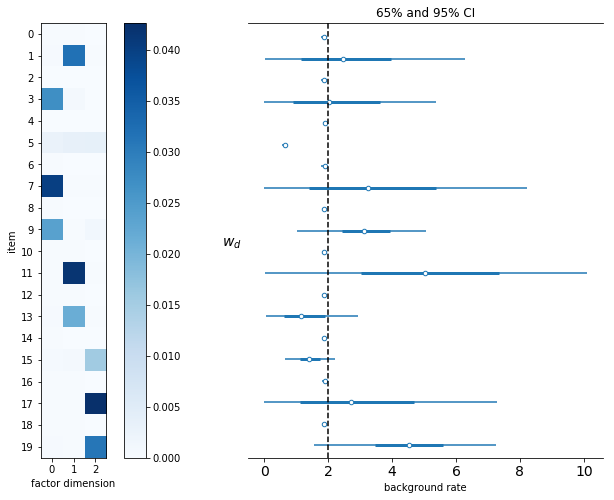

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(2.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()
